# Monitoring wetlands in the Okavango

* **Products used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[wofs_ls](https://explorer.digitalearth.africa/wofs_ls), 
[fc_ls](https://explorer.digitalearth.africa/fc_ls)

### Background

The `Wetlands Insight Tool (WIT)` provides insights into a wetland's seasonal and interannual dynamics. The WIT is a spatiotemporal summary of an wetland that combines multiple datasets derived from the Landsat archive held within DE Africa. `Fractional cover`, `WOfS`, and `Landsat surface reflectance` data are retrieved from DE Africa's ODC and combined to produce a stack plot describing the percentage of a wetland polygon as vegetation fractional cover, open water, and wet vegetation through time.  

> `Detailed Explanation:`
Data is retrieved for timesteps containing more than 80% cloud-free data (you can adjust this number in the code below). The code calculates the Tasselled-Cap Wetness (TCW, or just 'wetness') from surface reflectance and takes the maximum Fractional cover fraction per pixel, masking Fractional cover with TCW, and masking TCW with open water. For each pixel inside or overlapping the polygon describing the wetland, WIT calculates the dominant fractional cover type. WIT selects the largest percentage value for each pixel as the dominant fractional cover type. Fractional cover was masked using WOfS and TCW to remove areas of water and wet vegetation from areas where fractional cover is calculated. This is necessary as the fractional cover algorithm erroneously classifies water as green vegetation (PV). The resulting output is a stacked plot of open water, wet vegetation, photosynthetic vegetation, non-photosynthetic vegetation, and bare soil for the wetland polygon through time.

### Description
This notebook will run the Wetlands Insight Tool for the area encompassed by a polygon. This notebook uses a default shapefile that provides an example wetland for running the analysis. The polygons in this shapefile were hand drawn from a basemap, and they are only provided for demonstration purposes, they are not meant to represent the true delineation of any specific wetland.

1.  Load in a shapefile
2.  Run the Wetlands Insight Tool
3.  Plot the results as a stacked line plot


## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.
***

### Load packages

In [1]:
import datacube
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry

from wetlands import WIT_drill

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import map_shapefile
from deafrica_tools.dask import create_local_dask_cluster


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35901 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

The following cell sets important parameters for the analysis:

* `shp_path`: a location path to the shapefile (e.g. `folder/input.shp`). 

* `time_range`: The date range to analyse (e.g. `('2015', '2019') `)

In [3]:
# shp_path = 'data/okavango_delta_outline.geojson'
shp_path = 'data/lake_ngami.geojson'

time_range = ('2014' , '2021-08')


### Load shapefile

We will also ensure the polygon is in WGS84 coordinates (`epsg=4326`) using the `to_crs()` method to make sure it can index the datacube correctly.

In [4]:
gdf = gpd.read_file(shp_path).to_crs('epsg:4326') 

### Plot the polygon

This cell will plot the polygon over a basemap using the `deafrica_tools.plotting` function `map_shapefile`

In [5]:
#plot the shapefile over a basemap
gdf['id']=0
map_shapefile(gdf, attribute='id', fillOpacity=0.1)

Label(value='')

Map(center=[-20.49287474173353, 22.721099853515625], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Run the Wetlands Insight Tool

Even for small areas, this code can take a long time to run so you will need to be patient. This is because the tool loads three seperate datasets (Landsat SR, Fractional Cover, and WOfS), and calculates a tasselled cap index on the fly. 

In [6]:
export_name='results/lake_ngami_WIT.csv'

In [7]:
df = WIT_drill(
    gdf=gdf,
    time=time_range,
    min_gooddata=0,
    TCW_threshold=-0.035,
    resample_frequency="1M",
    export_csv=export_name,
    dask_chunks=dict(x=1000, y=1000, time=1),
    verbose=False,
)

df.head()

,wofs_area_percent,wet_percent,green_veg_percent,dry_veg_percent,bare_soil_percent
2014-01-31,32.89,1.36,40.59,1.25,23.91
2014-02-28,32.58,0.61,53.43,2.07,11.31
2014-03-31,33.02,2.31,61.81,0.86,2.00
2014-04-30,32.88,3.09,54.43,4.19,5.41
2014-05-31,32.28,1.56,28.05,29.71,8.39


## Plot the results

If you would like to export the plot as a .png file, then set the variable below to `True`, and give the plot a `name` (e.g. the wetland's name)

In [8]:
export_plot = True
out_filename = 'results/Lake_Ngami_WIT.png'

<Figure size 432x288 with 0 Axes>

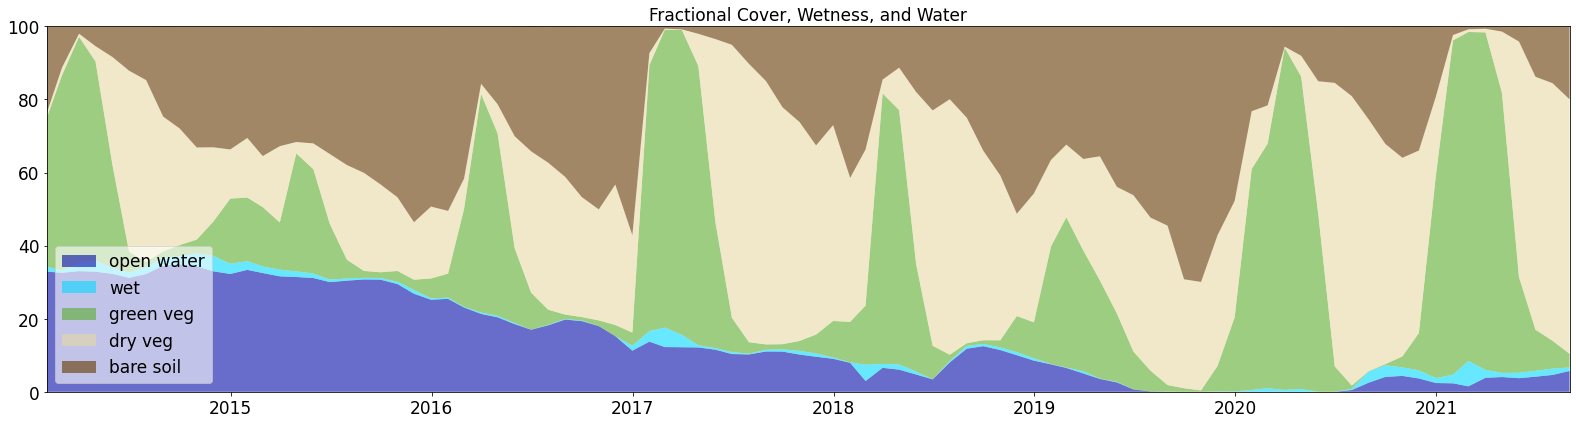

In [9]:
fontsize = 17

# generate plot

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

#make a stacked area plot
plt.clf()
fig=plt.figure(figsize = (22,6))
plt.stackplot(df.index, 
              df.wofs_area_percent, 
              df.wet_percent, 
              df.green_veg_percent, 
              df.dry_veg_percent,
              df.bare_soil_percent,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)

#set axis limits to the min and max
plt.axis(xmin = df.index[0], xmax = df.index[-1], ymin = 0, ymax = 100, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6, fontsize=fontsize)
plt.title('Fractional Cover, Wetness, and Water', fontsize=fontsize)
plt.tight_layout();
if export_plot:
    #save the figure
    plt.savefig(out_filename);


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feb 2020

**Compatible `datacube` version:** 

In [10]:
print(datacube.__version__)

1.8.5
